# M-ECLIPSES Basic Results Analysis Tutorial

This notebook demonstrates how to load and analyze instrument response simulation results from the M-ECLIPSES package.

## Overview

After running a Monte Carlo simulation with multiple parameter combinations, you'll have a results file containing:
- Fit statistics (mean, standard deviation, and first fit results)
- Ground truth values for comparison
- Parameter combinations tested
- Synthetic data arrays (photon counts and DN)

This notebook shows you how to:
1. Load simulation results
2. Explore available parameter combinations
3. Extract results for specific combinations
4. Analyze fit statistics to compute velocity and line width errors
5. Create SunPy maps for visualization

## 1. Import Required Libraries

First, let's import the necessary libraries and the M-ECLIPSES analysis functions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import sunpy.map
from pathlib import Path

# Import M-ECLIPSES analysis functions
from euvst_response import (
    load_instrument_response_results,
    get_parameter_combinations,
    summary_table,
    get_results_for_combination,
    analyse_fit_statistics,
    create_sunpy_maps_from_combo
)

# Set up matplotlib
plt.rcParams['figure.figsize'] = (8, 4)

/gpfs/data/fs70652/jamesm/venvs/solar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Simulation Results

Replace the path below with the path to your simulation results file.

In [2]:
# Path to your results file
results_file = "run/result/instrument_response_example.pkl"

# Load the results
results = load_instrument_response_results(results_file)

print(f"Loaded results with {len(results['results']['all_combinations'])} parameter combinations")

Loaded results with 1 parameter combinations


## 3. Explore Available Parameter Combinations

Let's see what parameter combinations were simulated.

In [3]:
# Get a summary of all parameter combinations
summary_table(results)

Parameter Combination Summary
Slit (arcsec) Oxide (nm)   Carbon (nm)  Al (Å)     CCD (°C)   Stray Light  Exp (s)   
------------------------------------------------------------------------------------------------------------------------
1.00         9.5          0.0          1485       -60.0      0            10.0      
------------------------------------------------------------------------------------------------------------------------
Total combinations: 1
Exposure times: [np.float64(10.0)]


In [4]:
# Get the list of parameter combinations
combinations = get_parameter_combinations(results)
print(f"Number of combinations: {len(combinations)}")
print(f"First few combinations: {combinations[:3]}")

# Show parameter ranges
param_ranges = results['results']['parameter_ranges']
print("\nParameter ranges:")
for param_name, values in param_ranges.items():
    print(f"  {param_name}: {values}")

Number of combinations: 1
First few combinations: [(np.float64(1.0), np.float64(9.5), np.float64(0.0), np.float64(1485.0), np.float64(-60.0), np.float64(0.0), np.float64(10.0))]

Parameter ranges:
  slit_widths: [<Quantity 1. arcsec>]
  oxide_thicknesses: [<Quantity 95. Angstrom>]
  c_thicknesses: [<Quantity 0. Angstrom>]
  aluminium_thicknesses: [<Quantity 1485. Angstrom>]
  ccd_temperatures: [<Quantity -60. deg_C>]
  vis_sl_vals: [<Quantity 0. ph / (pix s)>]
  exposures: [<Quantity 10. s>]


## 4. Extract Results for a Specific Parameter Combination

Now let's get results for a specific parameter combination. You can specify the exact parameters you want, or use defaults.

In [ ]:
# Get results using specific parameters.
# If you don't specify enough parameters for a unique combination, you will get an error.
combination_results = get_results_for_combination(
    results,
    slit_width=1 * u.arcsec,
    oxide_thickness=9.5 * u.nm,
    c_thickness=0 * u.nm,
    aluminium_thickness=1485 * u.AA,
    ccd_temperature=-60.0 * u.deg_C,
    vis_sl=0 * u.photon / (u.s * u.pix),
    exposure=10 * u.s
)

print("Selected parameter combination:")
for key, value in combination_results['parameters'].items():
    print(f"  {key}: {value}")

Selected parameter combination:
  slit_width: 1.0 arcsec
  oxide_thickness: 95.0 Angstrom
  c_thickness: 0.0 Angstrom
  aluminium_thickness: 1485.0 Angstrom
  ccd_temperature: -60.0 deg_C
  vis_sl: 0.0 ph / (pix s)
  exposure: 10.0 s


## 5. Create Histogram Plots

Let's visualize the velocity and error distributions. 

1. The standard deviation in the between all the Monte Carlo runs is used to estimate the uncertainty in the velocity measurement.
2. The difference between the Doppler velocity fitted before and after detector effects is used to estimate the systematic error in the velocity measurement (i.e. from the PSF).

In [6]:
# Set the rest wavelength for velocity calculations (Fe XII line)
rest_wavelength = 195.119 * u.AA

# Analyze fit statistics for DN data
dn_analysis = analyse_fit_statistics(
    combination_results, 
    rest_wavelength, 
    data_type="dn"
)

# Compare with photon-level analysis (before detector effects)
photon_analysis = analyse_fit_statistics(
    combination_results, 
    rest_wavelength, 
    data_type="photon"
)

/tmp/ipykernel_1476820/893029316.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


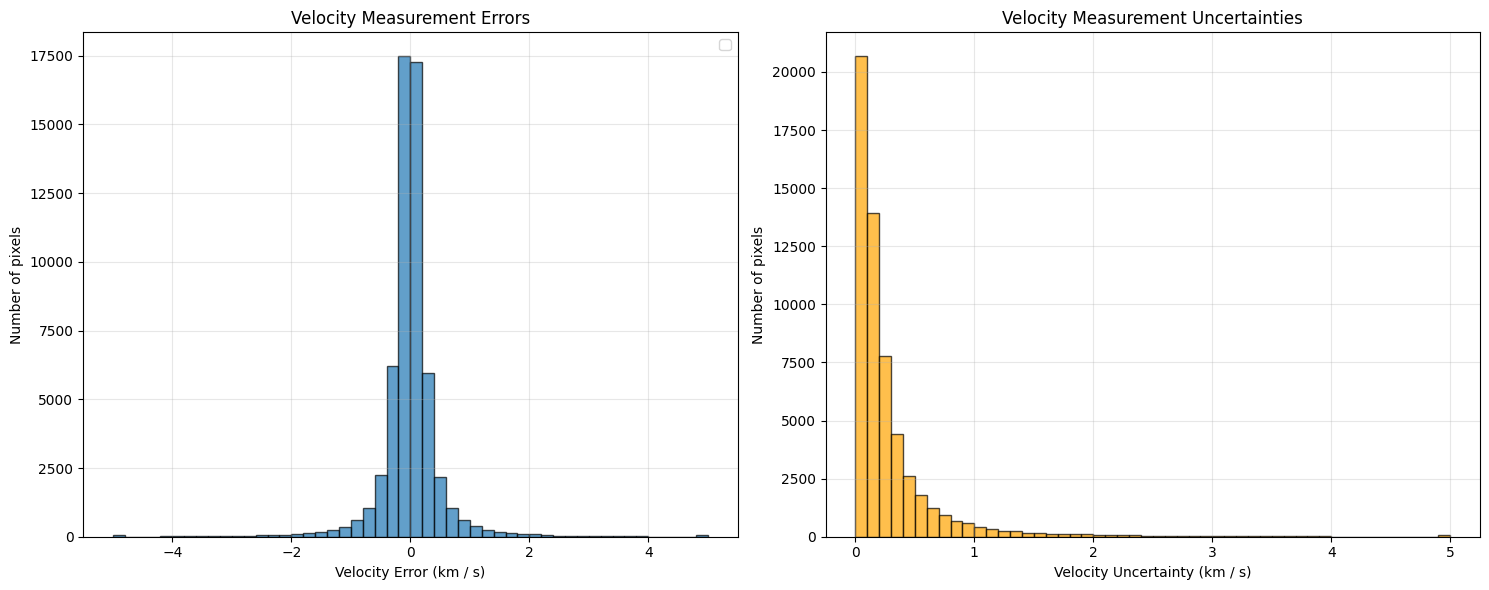

In [7]:
# Plot velocity error histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Velocity errors
v_err_flat = dn_analysis['v_err'].flatten().clip(min=-5 * u.km / u.s, max=5 * u.km / u.s)
ax1.hist(v_err_flat.value, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel(f'Velocity Error ({v_err_flat.unit})')
ax1.set_ylabel('Number of pixels')
ax1.set_title('Velocity Measurement Errors')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Velocity uncertainties
v_std_flat = dn_analysis['v_std'].flatten().clip(min=0 * u.km / u.s, max=5 * u.km / u.s)
ax2.hist(v_std_flat.value, bins=50, alpha=0.7, edgecolor='black', color='orange')
ax2.set_xlabel(f'Velocity Uncertainty ({v_std_flat.unit})')
ax2.set_ylabel('Number of pixels')
ax2.set_title('Velocity Measurement Uncertainties')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Create SunPy Maps

Now let's create SunPy maps for spatial visualization. We need to provide a cube with helioprojective WCS coordinates.

In [8]:
# Get cube_reb from the results - this contains the helioprojective WCS
cube_reb = results.get("cube_reb")

# Create SunPy maps
maps = create_sunpy_maps_from_combo(
    combination_results,
    cube_reb,
    rest_wavelength=rest_wavelength,
    data_type="dn"
)

print(f"Created {len(maps)} SunPy maps:")
for map_name in maps.keys():
    print(f"  - {map_name}")

Created 9 SunPy maps:
  - total_photons
  - total_dn
  - velocity_from_fit
  - velocity_mean
  - velocity_std
  - velocity_err
  - line_width_from_fit
  - line_width_mean
  - line_width_std


## 7. Display SunPy Maps

Now let's display the SunPy maps we created above.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


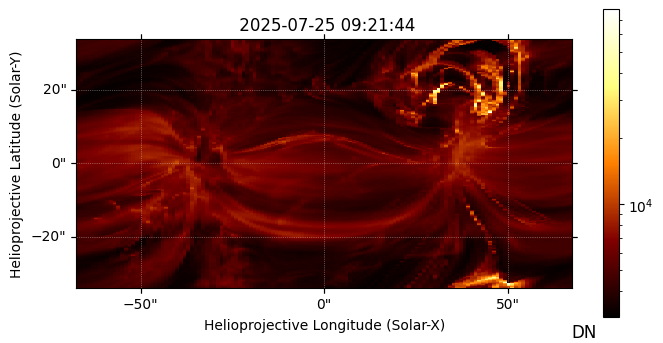

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


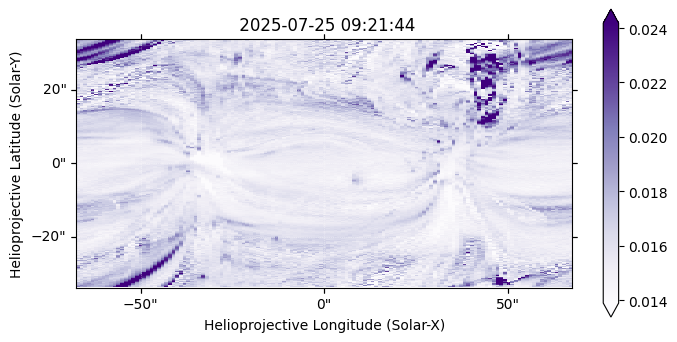

In [9]:
# Quicklook at a DN map
maps['total_dn'].peek()

# Plot a line width map
line_width_map = maps['line_width_from_fit']
fig = plt.figure()
ax = fig.add_subplot(projection=line_width_map)
im = line_width_map.plot(axes=ax, clip_interval=(1, 99)*u.percent)
plt.colorbar(im, extend='both')
plt.show()